In [1]:
#conda install --channel conda-forge carterbox-torch-radon
#pip install matplotlib
#!pip install opencv-python
#!sudo apt update && apt install -y libsm6 libxext6
#!sudo apt-get install -y libxrender-dev
#!nvidia-smi

Mon Jan 22 13:27:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A2                      Off | 00000000:B1:00.0 Off |                    0 |
|  0%   51C    P8               9W /  60W |      4MiB / 15356MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import torch
import numpy as np

from modules.operators.RadonTorch import RadonTorch
from modules.operators.Wavelet import Wavelet
import numpy as np
from modules.algorithm.ConjugateGradient import ConjugateGradient as CG
from modules.models.MetaInvNet import *
import torch
import torch_radon as tr
import os
import s3fs
from math import sqrt


device = 'cuda'

In [4]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

BUCKET_X_TRUE_TRAIN = "antoinedp/x_true_train"
BUCKET_X_TRUE_TEST = "antoinedp/x_true_test"
BUCKET_X_FBP_TRAIN = "antoinedp/x_fbp_train"
BUCKET_X_FBP_TEST = "antoinedp/x_fbp_test"

x_true_train_filenames = fs.ls(BUCKET_X_TRUE_TRAIN)[1:]
x_true_test_filenames = fs.ls(BUCKET_X_TRUE_TEST)[1:]
x_fbp_train_filenames = fs.ls(BUCKET_X_FBP_TRAIN)[1:]
x_fbp_test_filenames = fs.ls(BUCKET_X_FBP_TEST)[1:]

In [5]:
import numpy as np

def import_data(file_paths):
    data = []
    for file_path in file_paths:
        with fs.open(file_path, mode="rb") as file_in:
            data.append(np.load(file_in, encoding="bytes"))
    return data
    
x_true_train = import_data(x_true_train_filenames)
x_true_test = import_data(x_true_test_filenames)

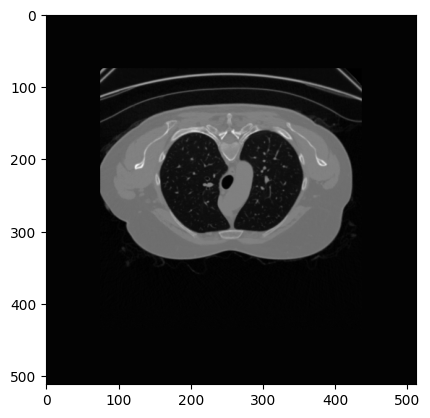

In [7]:
plt.imshow(x_true_train[90], cmap="gray")
plt.show()

In [8]:
y_train, y_test = x_true_train, x_true_test

In [9]:
y_train_tensor = torch.from_numpy(np.array(y_train)).to(dtype=torch.float32).to(device)
y_test_tensor = torch.from_numpy(np.array(y_test)).to(dtype=torch.float32).to(device)

In [10]:
import torchvision.transforms as transforms

# set projector

angles = np.linspace(0, np.pi, 52, endpoint=False)
volume = tr.Volume2D()
volume.set_size(height=512, width=512)
radon = RadonTorch(512, angles, volume)
wavelet = Wavelet()


normalize_x = transforms.Compose([
    transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min()))  #transforms.Normalize(mean=[mean_x_train], std=[std_x_train]) 
])

normalize_y = transforms.Compose([
    transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min()))  #transforms.Normalize(mean=[mean_y_train], std=[std_y_train]) 
])

normalize_sino = transforms.Compose([
    transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min()))  #transforms.Normalize(mean=[mean_sino_train], std=[std_sino_train]) 
])


y_train_tensor_normalized = []
for xtrue_train in y_train_tensor:
    y_train_tensor_normalized.append(normalize_y(xtrue_train))

y_test_tensor_normalized = []
for xtrue_test in y_test_tensor:
    y_test_tensor_normalized.append(normalize_y(xtrue_test))

y_train_tensor = torch.stack(y_train_tensor_normalized)
y_test_tensor = torch.stack(y_test_tensor_normalized)

sinos_train = []
for xtrue_train in y_train_tensor:
    sinos_train.append(radon.transform(xtrue_train).to(device))

sinos_test = []
for xtrue_test in y_test_tensor:
    sinos_test.append(radon.transform(xtrue_test).to(device))


X_train = []
for xtrue_train in y_train_tensor:
    sinogram = radon.transform(xtrue_train)
    filtered_sinogram = radon.radon.filter_sinogram(sinogram)
    fbp = radon.transposed_transform(filtered_sinogram)
    X_train.append(fbp.to(device))

X_test = []
for xtrue_test in y_test_tensor:
    sinogram = radon.transform(xtrue_test)
    filtered_sinogram = radon.radon.filter_sinogram(sinogram)
    fbp = radon.transposed_transform(filtered_sinogram)
    X_test.append(fbp.to(device))


sinos_train_tensor = torch.stack(sinos_train)
sinos_test_tensor = torch.stack(sinos_test)
X_train_tensor = torch.stack(X_train)
X_test_tensor = torch.stack(X_test)

/opt/mamba/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/mamba/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


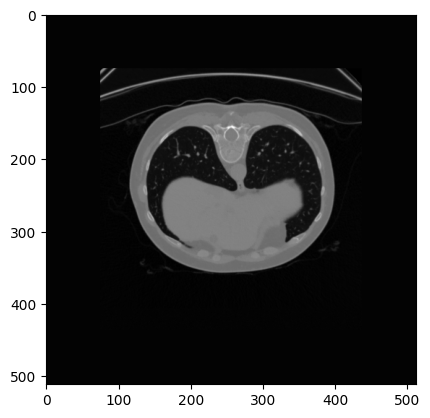

In [11]:
img_x_= y_train_tensor[5].to('cpu').squeeze(0).numpy()
plt.imshow(img_x_, cmap = 'gray')
plt.show()

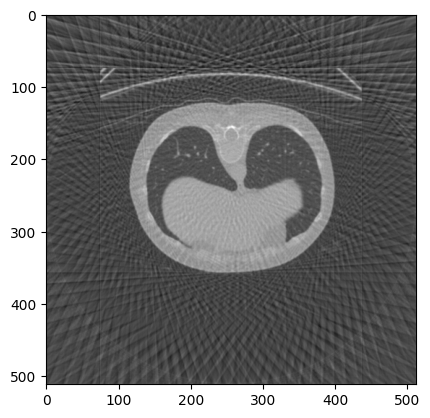

In [12]:
img_x_= X_train_tensor[5].to('cpu').squeeze(0).numpy()
plt.imshow(img_x_, cmap = 'gray')
plt.show()

In [13]:
X_train_tensor = X_train_tensor.unsqueeze(1)
X_test_tensor = X_test_tensor.unsqueeze(1)
y_train_tensor = y_train_tensor.unsqueeze(1)
y_test_tensor = y_test_tensor.unsqueeze(1)
sinos_train_tensor = sinos_train_tensor.unsqueeze(1)
sinos_test_tensor = sinos_test_tensor.unsqueeze(1)

In [15]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, im1, im2, im3):
        super(CustomDataset, self).__init__()
        self.im1 = im1
        self.im2 = im2
        self.im3 = im3

    def __getitem__(self, index):
        return self.im1[index,], self.im2[index,], self.im3[index,]

    def __len__(self):
        return len(self.im1)


dataloader_train = DataLoader(CustomDataset(sinos_train_tensor, X_train_tensor, y_train_tensor), batch_size=1, shuffle=True)
dataloader_test = DataLoader(CustomDataset(sinos_test_tensor, X_test_tensor, y_test_tensor), batch_size=1, shuffle=True)

In [16]:
def train_loop(dataloader, model, loss_fn, optimizer, scheduler, device):
    size = len(dataloader.dataset)
    model.train()
    for batch, (sino, X, y) in enumerate(dataloader):
        sino = sino.to(device)
        X = X.to(device)
        y = y.to(device)
        
        # Compute prediction and loss
        pred = model(sino, X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Display loss from time to time
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss: >7f}  [{current: >5d} / {size: >5d}]")
            print(model.gammak, model.lambak)

    scheduler.step()
    



def test_loop(dataloader, model, loss_fn, device, set = "Test"):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for sino, X, y in dataloader:
            sino = sino.to(device)
            X = X.to(device)
            y = y.to(device)

            pred = model(sino, X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print(f"\n{set} set: Avg loss: {test_loss: >8f} \n")
    return test_loss


def train(model, train_dataloader, test_dataloader, loss_fn, optimizer, scheduler, epochs, device, start_epoch = 0):
    for t in range(start_epoch, epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_dataloader, model, loss_fn, optimizer, scheduler, device)
        
        torch.save({'epoch': t,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': loss_fn}, 
        	'./metainvnet_autoparams.pth')
        
        test_loop(train_dataloader, model, loss_fn, device, set = "Training")
        test_loop(test_dataloader, model, loss_fn, device)

In [17]:
from torch.optim import lr_scheduler, SGD, Adam
from modules.models.MetaInvNet import *


class TVTorch:
    
    def transform(self, x):
        
        x1 = (x - torch.roll(x, shifts=(0, 1), dims=(2, 3))) 
        x2 = (x - torch.roll(x, shifts=(0, -1), dims=(2, 3))) 
        x3 = (x - torch.roll(x, shifts=(1, 0), dims=(2, 3))) 
        x4 = (x - torch.roll(x, shifts=(-1, 0), dims=(2, 3))) 
        
        x5 = (1/sqrt(2)) * (x - torch.roll(x, shifts=(1, -1), dims=(2, 3))) 
        x6 = (1/sqrt(2)) * (x - torch.roll(x, shifts=(-1, 1), dims=(2, 3))) 
        x7 = (1/sqrt(2)) * (x - torch.roll(x, shifts=(1, 1), dims=(2, 3))) 
        x8 = (1/sqrt(2)) * (x - torch.roll(x, shifts=(-1, -1), dims=(2, 3))) 
        
        return torch.cat((x1, x2, x3, x4, x5, x6, x7, x8), dim=1)
    
    def transposed_transform(self, x):
        
        x1 = (x[:,0:1,:,:] - torch.roll(x[:,0:1,:,:], shifts=(0, -1), dims=(2, 3)))
        x2 = (x[:,1:2,:,:] - torch.roll(x[:,1:2,:,:], shifts=(0, 1), dims=(2, 3)))
        x3 = (x[:,2:3,:,:] - torch.roll(x[:,2:3,:,:], shifts=(-1, 0), dims=(2, 3)))
        x4 = (x[:,3:4,:,:] - torch.roll(x[:,3:4,:,:], shifts=(1, 0), dims=(2, 3)))
        
        x5 = (1/sqrt(2)) * (x[:,4:5,:,:] - torch.roll(x[:,4:5,:,:], shifts=(-1, 1), dims=(2, 3)))
        x6 = (1/sqrt(2)) * (x[:,5:6,:,:] - torch.roll(x[:,5:6,:,:], shifts=(1, -1), dims=(2, 3)))
        x7 = (1/sqrt(2)) * (x[:,6:7,:,:] - torch.roll(x[:,6:7,:,:], shifts=(-1, -1), dims=(2, 3)))
        x8 = (1/sqrt(2)) * (x[:,7:8,:,:] - torch.roll(x[:,7:8,:,:], shifts=(1, 1), dims=(2, 3)))
        
        return x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8


def ssim_loss(img1, img2, size=11,sigma = 1.5, cs_map=False):
    if isinstance(img1, torch.Tensor):
        img1 = img1.unsqueeze(0)
        img2 = img2.unsqueeze(0)

    window = fspecial_gauss(size, sigma)
    window = torch.from_numpy(window.copy()).unsqueeze(0).unsqueeze(0).type(torch.FloatTensor).cuda()
    window = torch.nn.Parameter(data=window, requires_grad=False)
    K1 = 0.001
    K2 = 0.03
    L = 2.0
    C1 = (K1 * L) ** 2
    C2 = (K2 * L) ** 2
    mu1 = F.conv2d(img1,window)
    mu2 = F.conv2d(img2,window)

    mu1_sq = mu1 * mu1
    mu2_sq = mu2 * mu2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = F.conv2d(img1 * img1, window )- mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window )- mu2_sq
    sigma12 = F.conv2d(img1 * img2, window )- mu1_mu2
    
    if cs_map:
        return (((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                             (sigma1_sq + sigma2_sq + C2)),
                (2.0 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2))
    else:
        ssim = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
        ssim = torch.clamp(ssim,min=0.0,max=1.0)
        return ssim.mean()

def l2loss_mean(x,y):
    assert x.size() == y.size()
    loss = torch.sum((x-y) ** 2)
    return loss

def fspecial_gauss(size, sigma):
    x, y = np.mgrid[-size // 2 + 1:size // 2 + 1, -size // 2 + 1:size // 2 + 1]
    g = np.exp(-((x ** 2 + y ** 2) / (2.0 * sigma ** 2)))
    return g / g.sum()

def loss_fun(db, sp):
    layer = len(db)
    loss = 0.0
    for ii in range(0, layer):
        loss =loss+ l2loss_mean(sp, db[ii]) * 1.1**ii
        for ii in range(0, layer):
            for jj in range(sp.shape[1]):
                img1=sp[jj,...]
                img2=db[ii][jj,...]

                ssim_value=1-ssim_loss(img1, img2,size=11,sigma = 1.5)
                loss=loss+ssim_value*100.0

        return loss


In [ ]:
from torch.optim import lr_scheduler, SGD, Adam

def ssim_loss(img1, img2, size=11,sigma = 1.5, cs_map=False):
    if isinstance(img1, torch.Tensor):
        img1 = img1.unsqueeze(0)
        img2 = img2.unsqueeze(0)

    window = fspecial_gauss(size, sigma)
    window = torch.from_numpy(window.copy()).unsqueeze(0).unsqueeze(0).type(torch.FloatTensor).cuda()
    window = torch.nn.Parameter(data=window, requires_grad=False)
    K1 = 0.001
    K2 = 0.03
    L = 2.0
    C1 = (K1 * L) ** 2
    C2 = (K2 * L) ** 2
    mu1 = F.conv2d(img1,window)
    mu2 = F.conv2d(img2,window)

    mu1_sq = mu1 * mu1
    mu2_sq = mu2 * mu2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = F.conv2d(img1 * img1, window )- mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window )- mu2_sq
    sigma12 = F.conv2d(img1 * img2, window )- mu1_mu2
    
    if cs_map:
        return (((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                             (sigma1_sq + sigma2_sq + C2)),
                (2.0 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2))
    else:
        ssim = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
        ssim = torch.clamp(ssim,min=0.0,max=1.0)
        return ssim.mean()

def l2loss_mean(x,y):
    assert x.size() == y.size()
    loss = torch.sum((x-y) ** 2)
    return loss

def fspecial_gauss(size, sigma):
    x, y = np.mgrid[-size // 2 + 1:size // 2 + 1, -size // 2 + 1:size // 2 + 1]
    g = np.exp(-((x ** 2 + y ** 2) / (2.0 * sigma ** 2)))
    return g / g.sum()


def loss_fun(db, sp):
    layer = len(db)
    loss = 0.0
    for ii in range(0, layer):
        loss =loss+ l2loss_mean(sp, db[ii]) * 1.1**ii
        for ii in range(0, layer):
            for jj in range(sp.shape[1]):
                img1=sp[jj,...]
                img2=db[ii][jj,...]

                ssim_value=1-ssim_loss(img1, img2,size=11,sigma = 1.5)
                loss=loss+ssim_value*100.0

        return loss



In [ ]:
# train 

tv = TVTorch()
epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelMetaInv = MetaInvNetL(10, radon, tv).to(device)
optimizer = Adam(modelMetaInv.parameters(), lr=1e-3)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[50,100], gamma=0.9)
loss = loss_fun



train(model=modelMetaInv,
      train_dataloader=dataloader_train,
      test_dataloader=dataloader_test,
      loss_fn=loss,
      optimizer=optimizer,
      scheduler=scheduler,
      epochs=epochs,
      device=device,
      start_epoch=start_epoch)

In [ ]:
def hqscg(Y, xk_L, zk, lam_over_gamma , gamma, projection, wavelet):

    for i in range(100):        
        xkp1_0 = xk_L

        AtY = projection.transposed_transform(Y)
        gammaWtzk = gamma * wavelet.transposed_transform(zk)
        AtAxkp1_0 = projection.transposed_transform(projection.transform(xkp1_0))
        Wtwxkp1_0 = gamma * wavelet.transposed_transform(wavelet.transform(xkp1_0))
        
        residual =  (AtY + gammaWtzk) - (AtAxkp1_0 + Wtwxkp1_0)

        # conjugate gradient
        rk = residual
        pk = residual
        xk = xkp1_0
        for i in range(25):
            
            rkTrk = torch.sum(rk**2,dim=(1,2,3))
            #compute Gpk where G = (ATA + lambda*WtW) (save results for future operations)
            Gpk = projection.transposed_transform(projection.transform(pk)) + gamma * wavelet.transposed_transform(wavelet.transform(pk))
            #compute pkGpk
            pkGpk = torch.sum(pk * Gpk, dim=(1,2,3))
    
            alphak = rkTrk/pkGpk
            alphak = alphak.view(-1,1,1,1)
            xk = xk + alphak*pk
            rk = rk - alphak*Gpk
            betak = torch.sum(rk**2,dim=(1,2,3)) / rkTrk
            betak = betak.view(-1,1,1,1)
            pk = rk + betak * pk

        xkp1_L = xk
        
        # soft tresholding
        Wxkp1_L = wavelet.transform(xkp1_L)
        zkp1 = F.relu(Wxkp1_L-lam_over_gamma) - F.relu(-Wxkp1_L-lam_over_gamma)

        xk_L=xkp1_L
        zk=zkp1

    disp =xk_L.clone().squeeze(0).squeeze(0).to('cpu').numpy()
    plt.imshow(disp, cmap="gray")
    plt.show()
    return disp

tv = TVTorch()
sino, img_x, img_y = next(iter(dataloader_train))
print(torch.max(img_x))

# grid search
I = [10**(-i) for i in range(7, -7, -1)]
J = [10**(-i) for i in range(7, -7, -1)]
Is = []
Js = []
vals = []

truth =img_y.clone().squeeze(0).squeeze(0).to('cpu').numpy()

for i in I:
    for j in J:
        pass
        print(i,j)
        x0 = torch.zeros(1,1,512,512).cuda()
        z0 = tv.transform(x0).cuda()
        val = hqscg(sino, x0, z0, i, j, radon, tv)
        norm = np.sum(np.abs(val - truth))
        Is.append(i)
        Js.append(j)
        vals.append(norm)
        print(norm)



In [ ]:
# to load model
modelMetaInv = MetaInvNetL(10, radon, tv).to(device)
checkpoint = torch.load('./metainvnet_autoparams.pth')
modelMetaInv.load_state_dict(checkpoint['model_state_dict'])
modelMetaInv.eval()

In [ ]:
sino, img_x, img_y = next(iter(dataloader_test))

z = modelMetaInv(sino, img_x)
prediction=z[10].detach().to('cpu').squeeze(0).squeeze(0).numpy()

truth=img_y.to('cpu').squeeze(0).squeeze(0).numpy()

plt.imshow(truth, cmap = 'gray')
plt.show()

plt.imshow(prediction, cmap = 'gray')
plt.show()